# Imports

In [1]:
# Data loading
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score
from IPython.display import clear_output

from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm


# Graph dataset
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset, Data

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedKFold


# GNN Model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphConv, GATConv, GATv2Conv, SAGEConv


# Sparse vector
from Sparse_vector.sparse_vector import SparseVector

# Data loading

In [2]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]

features = [i[:-4] for i in os.listdir('data/hg19_features/')]
groups = ['DNase-seq', 'Histone', 'RNA polymerase', 'TFs and others']
feature_names = [i for i in features if (i.split('_')[0] in groups)]

In [3]:
def chrom_reader(chrom):
    files = sorted([i for i in os.listdir(f'data/hg19_dna/') if f"{chrom}_" in i])
    return ''.join([load(f"data/hg19_dna/{file}") for file in files])

In [4]:
DNA = {chrom:chrom_reader(chrom) for chrom in tqdm(chrom_names)}
ZDNA = load('data/hg19_zdna/ZDNA.pkl')

DNA_features = {feture: load(f'data/hg19_features/{feture}.pkl')
                for feture in tqdm(feature_names)}

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1054 [00:00<?, ?it/s]

# Data selection

In [5]:
class GraphDataset(Dataset):
    def __init__(self, chroms, features, 
                 dna_source, features_source, 
                 labels, intervals, 
                 transform=None, pre_transform=None, pre_filter=None):
        self.chroms = chroms
        self.features = features
        self.dna_source = dna_source
        self.features_source = features_source
        self.labels = labels
        self.intervals = intervals
        self.le = LabelBinarizer().fit(np.array([["A"], ["C"], ["T"], ["G"]]))
        
        self.ei = [[],[]]
        for i in range(5000-1):
            self.ei[0].append(i)
            self.ei[0].append(i+1)
            self.ei[1].append(i+1)
            self.ei[1].append(i)
        
        super().__init__(transform, pre_transform, pre_filter)

    def __len__(self):
        return len(self.intervals)

    def __getitem__(self, idx):
        interval = self.intervals[idx]
        chrom = interval[0]
        begin = int(interval[1])
        end = int(interval[2])
        dna_OHE = self.le.transform(list(self.dna_source[chrom][begin:end].upper()))
        
        feature_matr = []
        for feature in self.features:
            source = self.features_source[feature]
            feature_matr.append(source[chrom][begin:end])
        
        if len(feature_matr) > 0:
            X = np.hstack((dna_OHE, np.array(feature_matr).T/1000)).astype(np.float32)
        else:
            X = dna_OHE.astype(np.float32)
        X = torch.tensor(X, dtype=torch.float)
        
        edge_index = torch.tensor(np.array(self.ei), dtype=torch.long)
        
        y = self.labels[interval[0]][interval[1]: interval[2]]
        y = torch.tensor(y, dtype=torch.int64)

        return Data(x=X, edge_index=edge_index, y=y)


In [6]:
width = 5000

np.random.seed(10)

ints_in = []
ints_out = []

for chrm in chrom_names:
    for st in trange(0, ZDNA[chrm].shape - width, width):
        interval = [st, min(st + width, ZDNA[chrm].shape)]
        if ZDNA[chrm][interval[0]: interval[1]].any():
            ints_in.append([chrm, interval[0], interval[1]])
        else:
            ints_out.append([chrm, interval[0], interval[1]])

ints_in = np.array(ints_in)
ints_out = np.array(ints_out)[np.random.choice(range(len(ints_out)), size=len(ints_in) * 3, replace=False)]

100%|██████████████████████████████████████████| 3/3 [00:00<00:00, 23519.46it/s]


In [7]:
equalized = np.vstack((ints_in, ints_out))
equalized = [[inter[0], int(inter[1]), int(inter[2])] for inter in equalized]

train_inds, test_inds = next(StratifiedKFold().split(equalized, [f"{int(i < 400)}_{elem[0]}"
                                                                 for i, elem 
                                                                 in enumerate(equalized)]))

train_intervals, test_intervals = [equalized[i] for i in train_inds], [equalized[i] for i in test_inds]

/home/arvo/miniconda3/envs/conda_38/lib/python3.8/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [8]:
train_dataset = GraphDataset(chrom_names, feature_names, 
                            DNA, DNA_features, 
                            ZDNA, train_intervals)

test_dataset = GraphDataset(chrom_names, feature_names, 
                           DNA, DNA_features, 
                           ZDNA, test_intervals)

In [9]:
params = {'batch_size':16,
          'num_workers':16,
          'shuffle':True}

loader_train = DataLoader(train_dataset, **params)
loader_test = DataLoader(test_dataset, **params)

# GNN model

In [10]:
class GraphZ(torch.nn.Module):
    def __init__(self):
        super(GraphZ, self).__init__()
        self.conv1 = SAGEConv(1058, 500)
        self.conv2 = SAGEConv(500, 100)
        self.conv3 = SAGEConv(100, 2)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.conv3(x, edge_index)

        return F.log_softmax(x, dim=1)

# Train and test

In [11]:
def loss_func(output, y_batch):
    return torch.nn.NLLLoss()(output, y_batch)


def train_epoch(model, optimizer):
    roc_auc_log, f1_log, acc_log, loss_log = [], [], [], []
    model.train()
    
    for dt in loader_train:
        x, edge, y = dt.x.cuda(), dt.edge_index.cuda(), dt.y.cuda().long()
        optimizer.zero_grad()
        
        output = model(x, edge)
        pred = torch.argmax(output, dim=1)
        y_pred = nn.Softmax(dim=1)(output)[:, 1].detach().cpu().numpy().flatten()
        
        if np.std(y.cpu().numpy().flatten()) == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(y.cpu().numpy().flatten(),
                                    nn.Softmax(dim=1)(output)[:, 1].detach().cpu().numpy().flatten())
        roc_auc_log.append(roc_auc)
        
        f1_log.append(f1_score(y.cpu().numpy().flatten(),
                         pred.cpu().numpy().flatten()))
        
        acc = torch.mean((pred == y).float())
        acc_log.append(acc.cpu().numpy())
        
        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    
    return roc_auc_log, f1_log, acc_log, loss_log


def test(model):
    roc_auc_log, f1_log, acc_log, loss_log = [], [], [], []
    model.eval()
    
    means = []
    for dt in loader_test:
        x, edge, y = dt.x.cuda(), dt.edge_index.cuda(), dt.y.cuda().long()
        
        output = model(x, edge)
        means.append(y.sum().cpu() / (1.0 * y.shape[0]))
        pred = torch.argmax(output, dim=1)
        
        if np.std(y.cpu().numpy().flatten()) == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(y.cpu().numpy().flatten(),
                                    nn.Softmax(dim=1)(output)[:, 1].detach().cpu().numpy().flatten())
        roc_auc_log.append(roc_auc)
        
        f1_log.append(f1_score(y.cpu().numpy().flatten(),
                                  pred.cpu().numpy().flatten()))
        
        acc = torch.mean((pred == y).float())
        acc_log.append(acc.cpu().numpy())
        
        loss = loss_func(output, y)
        loss = loss.item()
        loss_log.append(loss)
    
    return roc_auc_log, f1_log, acc_log, loss_log


def plot_history(train_history, valid_history, title, BatchSize, epoch_to_show=20):
    plt.figure(figsize=(epoch_to_show, 4))
    plt.title(title)    
    
    epoch_num = len(valid_history)
    train_history = np.array([None] * (BatchSize * epoch_to_show) + train_history)
    valid_history = np.array([None] * epoch_to_show + valid_history)
    
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, (epoch_to_show+1)*BatchSize), 
             train_history[-(epoch_to_show+1)*BatchSize:], c='red', label='train')
    plt.plot(np.linspace(epoch_num-epoch_to_show+1, epoch_num+1, epoch_to_show+1),
                valid_history[-epoch_to_show-1:], c='green', label='test')
    
    plt.ylim((0, 1))
    plt.yticks(np.linspace(0, 1, 11))
    plt.xticks(np.arange(epoch_num-epoch_to_show+1, epoch_num+2), 
                np.arange(epoch_num-epoch_to_show, epoch_num+1).astype(int))
    plt.xlabel('train steps')
    plt.legend(loc='best')
    plt.grid()
    plt.show()


def train(model, opt, n_epochs):  
    train_auc_log, train_f1_log, train_acc_log, train_loss_log = [], [], [], []
    val_auc_log, val_f1_log, val_acc_log, val_loss_log = [], [], [], []
    
    for epoch in range(n_epochs):
        print("Epoch {} of {}".format(epoch + 1, n_epochs))
        train_auc, train_f1, train_acc, train_loss = train_epoch(model, opt)
        val_auc, val_f1, val_acc, val_loss = test(model)
                
        train_auc_log.extend(train_auc)
        train_f1_log.extend(train_f1)
        train_acc_log.extend(train_acc)
        train_loss_log.extend(train_loss)
        
        val_auc_log.append(np.mean(val_auc))
        val_f1_log.append(np.mean(val_f1))
        val_acc_log.append(np.mean(val_acc))
        val_loss_log.append(np.mean(val_loss))
        
        
        clear_output()
        plot_history(train_auc_log, val_auc_log, 'Auc', len(train_loss))
        plot_history(train_f1_log, val_f1_log, 'F1', len(train_loss))
        print("Epoch {}: ROC-AUC = {:.2%}".format(epoch+1, val_auc_log[-1]))
        print("Epoch {}: F1-score = {:.3}".format(epoch+1, val_f1_log[-1]))
            
    
    print("Final ROC-AUC = {:.4}%".format(val_auc_log[-1]*100))
    print("Final F1-score = {:.3}".format(val_f1_log[-1]))

    return val_auc_log, val_f1_log, val_acc_log, val_loss_log

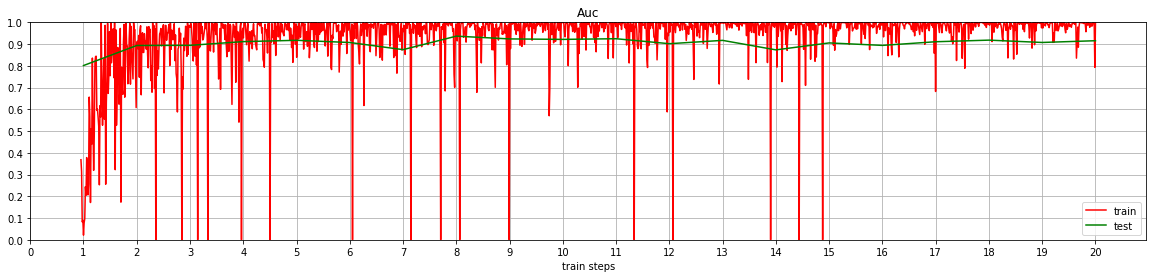

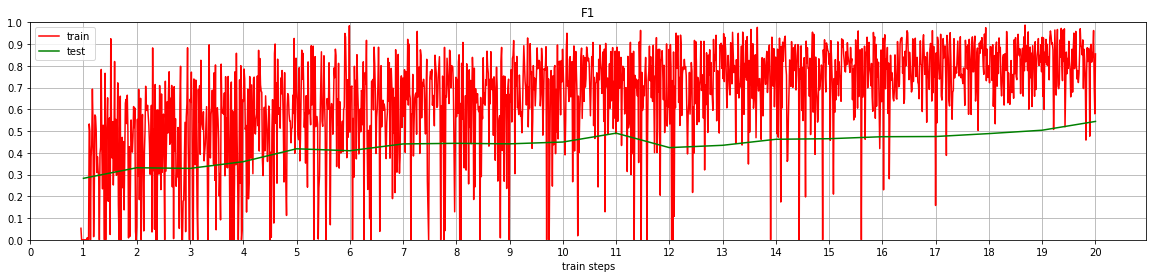

Epoch 20: ROC-AUC = 91.56%
Epoch 20: F1-score = 0.544
Final ROC-AUC = 91.56%
Final F1-score = 0.544
CPU times: user 6min 5s, sys: 2min 51s, total: 8min 57s
Wall time: 13min 39s


In [12]:
%%time
model = GraphZ()
model = model.cuda()

opt = torch.optim.RMSprop(model.parameters(), lr=10**-4, weight_decay=10**-4)

val_auc_log, val_f1_log, val_acc_log, val_loss_log = train(model, opt, 20)

In [13]:
#torch.save(model, 'gnn.pth')